### Import Libraries

In [1]:
import os
import ee
import geemap
import geemap.chart as chart
from geemap import cartoee
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipygee as ui
from skimage.filters import threshold_otsu
from skimage.filters import threshold_li
from skimage.filters import threshold_local
from collections import namedtuple
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Get Addis Ababa boundary data

In [2]:
# Get basemap layer and set it to Addis Ababa
map = geemap.Map(center=(8.9801, 38.7805), zoom=11)

In [3]:
# Get Addis boundary shapefile from https://data.humdata.org/dataset/cod-ab-eth
addis_shpfile = "C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/data/input_data/admin_boundaries/addis_bndry_py_hdx_2021.shp"
addis_bndry = geemap.shp_to_ee(addis_shpfile)

### Pre-process and filter data

In [4]:
# Set area of interest covering Addis Ababa
aoi = ee.Geometry.Point([38.7805, 8.9801])

# Data required
LS_8 = "LANDSAT/LC08/C02/T1_L2"
LS_7 = "LANDSAT/LE07/C02/T1_L2"
LS_5 = "LANDSAT/LT05/C02/T1_L2"

# # Set date filters
start = ee.Date('1991-01-01')
date_today = datetime.date.today().strftime('%Y-%m-%d')
end = ee.Date(date_today)

# Set additional filters 
cloud = ee.Filter.lt("CLOUD_COVER", 5)
season = ee.Filter.calendarRange(10, 2, 'month')
order = "system:time_start"

# Filter the collection
def filter_cltn(cltn, aoi, cloud, startDate, endDate, season, order):
    return ee.ImageCollection(cltn)\
    .filterBounds(aoi)\
    .filter(cloud)\
    .filterDate(startDate, endDate)\
    .filter(season)\
    .sort(order)\
    .map(lambda image: image.clip(addis_bndry))

In [5]:
# Code obtained from a combination of 
# https://github.com/giswqs/geemap/blob/ca365d23a10dbbbb29ff3ff5cd29acc89f42d10f/geemap/timelapse.py#L2075
# and https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

### Function to mask out clouds and apply scaling factors
def fmask(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True).updateMask(qaMask)


### Function to rename Landsat 5 and 7 bands. 
def Bands_L5_L7(L5_L7imgs):
    return L5_L7imgs.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )


### Function to rename Landsat 5 and 7 bands. 
def Bands_L8(L8imgs):
    return L8imgs.select(
        ["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )

### Functions to prepare and resample Landsat 5, 7 and 8 imagery.
def prepL8(img):
    orig = img
    img = fmask(img)
    img = Bands_L8(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

def prep_L5L7(img):
    orig = img
    img = fmask(img)
    img = Bands_L5_L7(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

### Add indices

In [6]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

def indices(img):
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")
    
    # PISI
    
    pisi = img.expression('(0.8192 * b("Blue") - 0.5735 * b("NIR") + 0.0750)').rename("PISI")
    
    return  img.addBands([ndbi, mndbi, bui, ibi, ENDISI, pisi])

### Merge collection and get annual sequence

In [7]:
### Adapted code from https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

# Setup vars to get dates.
startYear = 1991
endYear = 2021
startMonth = 10
startDay = 1
nDays = 151

# Get annual median collection.    
def getAnnualComp(y):
    startDate = ee.Date.fromYMD(
    ee.Number(y), ee.Number(startMonth), ee.Number(startDay))
    endDate = startDate.advance(ee.Number(nDays), 'day')

    # Filter collections and prepare them for merging.
    t_LC08coly = filter_cltn(LS_8, aoi, cloud, startDate, endDate, season, order).map(prepL8)
    t_LE07coly = filter_cltn(LS_7, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)
    t_LT05coly = filter_cltn(LS_5, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)
    
    # .map(lambda image: image.unmask(-9999))

    # Merge the collections.
    col = t_LC08coly.merge(t_LE07coly).merge(t_LT05coly)
    
    yearImg = col.median()
    nBands = yearImg.bandNames().size()
    yearImg = ee.Image(ee.Algorithms.If(
        nBands,
        yearImg,
        dummyImg))
    return(indices(yearImg)
           .set({'year': y, 'system:time_start': startDate.millis(), 'nBands': nBands}))

# # Make a dummy image for missing years.
bandNames = ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])
fillerValues = ee.List.repeat(0, bandNames.size())
dummyImg = ee.Image.constant(fillerValues).rename(bandNames).selfMask().int16()

# Get a list of years
years = ee.List.sequence(startYear, endYear)

# Make list of annual image composites.
imgList = years.map(getAnnualComp)

# Convert image composite list to collection
imgCol = ee.ImageCollection.fromImages(imgList)

# check the first image in the collection
first_collated = imgCol.first()

# get the size of the collection
size = imgCol.size().getInfo()

### Get annual images from the collection

In [8]:
y_1991 = ee.Image(imgList.get(0))
y_1992 = ee.Image(imgList.get(1))
y_1993 = ee.Image(imgList.get(2))
y_1994 = ee.Image(imgList.get(3))
y_1995 = ee.Image(imgList.get(4))
y_1996 = ee.Image(imgList.get(5))

y_1998 = ee.Image(imgList.get(7))
y_1999 = ee.Image(imgList.get(8))
y_2000 = ee.Image(imgList.get(9))
y_2001 = ee.Image(imgList.get(10))
y_2002 = ee.Image(imgList.get(11))
y_2003 = ee.Image(imgList.get(12))
y_2004 = ee.Image(imgList.get(13))
y_2005 = ee.Image(imgList.get(14))
y_2006 = ee.Image(imgList.get(15))
y_2007 = ee.Image(imgList.get(16))
y_2008 = ee.Image(imgList.get(17))
y_2009 = ee.Image(imgList.get(18))
y_2010 = ee.Image(imgList.get(19))
y_2011 = ee.Image(imgList.get(20))
y_2012 = ee.Image(imgList.get(21))
y_2013 = ee.Image(imgList.get(22))
y_2014 = ee.Image(imgList.get(23))
y_2015 = ee.Image(imgList.get(24))
y_2016 = ee.Image(imgList.get(25))
y_2017 = ee.Image(imgList.get(26))
y_2018 = ee.Image(imgList.get(27))
y_2019 = ee.Image(imgList.get(28))
y_2020 = ee.Image(imgList.get(29))
y_2021 = ee.Image(imgList.get(30)) 

annual_list = [y_1991, y_1992, y_1993, y_1994, y_1995, y_1996, y_1998, y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, 
               y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019,
              y_2020, y_2021]

### Get Image Arrays

In [9]:
# code obtained from 
# https://github.com/mvpeppa/Remote-Sensing-Tests-with-Google-Earth-Engine/blob/main/Waterline%20extraction%20e.g.%20Lake%20Koka%20Ethiopia.ipynb

def img2array1D(img, band):
    # extract the data from an ee.image
    img = img.select(band)
    # extract the pixel values from the image
    info = img.reduceRegion(ee.Reducer.toList(), geometry=addis_bndry, scale=30)
    # Convert to an 1D array for further use
    data = np.array((ee.Array(info.get(band)).getInfo()))
    return data

In [10]:
annual_list = [y_1991, y_1992, y_1993, y_1994, y_1995, y_1996, y_1998, y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, 
               y_2005, y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, 
               y_2018, y_2019, y_2020, y_2021]

annual_list_names = ["y_1991", "y_1992", "y_1993", "y_1994", "y_1995", "y_1996", "y_1998", "y_1999", "y_2000", "y_2001", 
                     "y_2002", "y_2003", "y_2004", "y_2005", "y_2006", "y_2007", "y_2008", "y_2009", "y_2010", "y_2011", 
                     "y_2012", "y_2013", "y_2014", "y_2015", "y_2016", "y_2017", "y_2018", "y_2019", "y_2020", "y_2021"]

list_of_bands = ["NDBI", "MNDBI", "IBI", "ENDISI", "PISI"]

year_output = []

for _,year in enumerate(annual_list):
    output = []
    
    for _,band in enumerate(list_of_bands):
        output.append(img2array1D(year, band))
    
    year_output.append(dict(zip(list_of_bands, output)))

array_dict = dict(zip(annual_list_names, year_output))

# pd.DataFrame(output_dict)

In [ ]:
# for key in array_dict["y_2015"].keys():
#     for value in array_dict["y_2015"][key]:
#         something = value
#         print(type(something))

In [ ]:
# array_df = pd.read_csv('band_arrays.csv')
# array_df.columns = array_df.columns.str.replace('Unnamed: 0', 'bands')
# array_df = array_df.set_index('bands')
# array_df

### Inspect the year 2020

In [11]:
array_2020 = array_dict["y_2020"]
array_2020

{'NDBI': array([-0.03558799, -0.05166422, -0.04307123, ..., -0.31149119,
        -0.27251521, -0.24729164]),
 'MNDBI': array([0.30990317, 0.31203216, 0.35014218, ..., 0.41916841, 0.45457405,
        0.44911999]),
 'IBI': array([ 0.00820604, -0.00936838,  0.00537441, ..., -0.21865869,
        -0.1862215 , -0.16127153]),
 'ENDISI': array([-0.35878722, -0.40211459, -0.3715101 , ..., -0.78390689,
        -0.78629041, -0.75771715]),
 'PISI': array([ 0.00392005,  0.00846255, -0.00795662, ..., -0.03653059,
        -0.03593575, -0.0339381 ])}

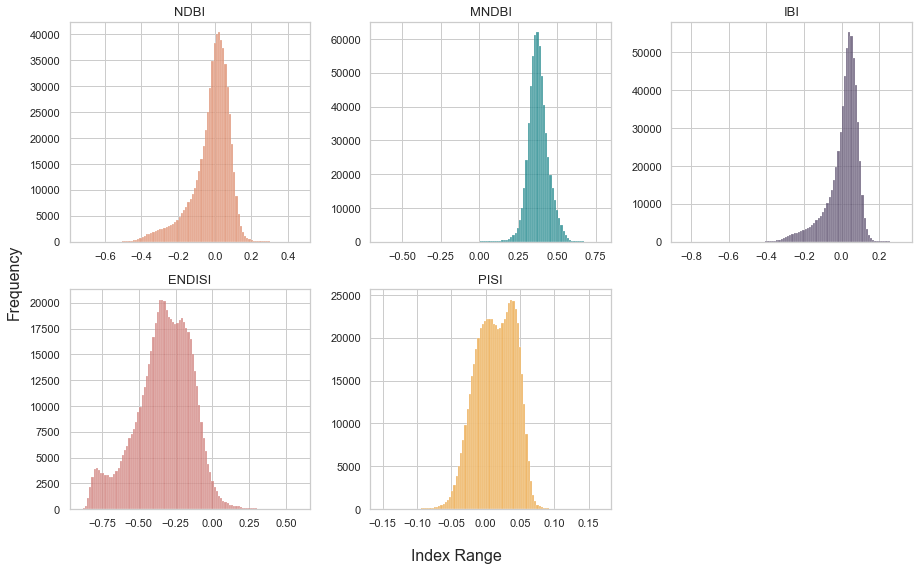

In [12]:
sns.set(style="whitegrid")  
fig,axs = plt.subplots(2,3, figsize = (13,8))

sns.histplot(array_2020["NDBI"], kde=False, color='#DC8665', bins=100, ax=axs[0, 0])
axs[0,0].set_title("NDBI", size=13)
axs[0,0].set_ylabel(None)

sns.histplot(array_2020["MNDBI"], kde=False, color='#138086', bins=100, ax=axs[0, 1])
axs[0,1].set_title("MNDBI", size=13)
axs[0,1].set_ylabel(None)

sns.histplot(array_2020["IBI"], kde=False, color='#534666', bins=100,ax=axs[0, 2])
axs[0,2].set_title("IBI", size=13)
axs[0,2].set_ylabel(None)

sns.histplot(array_2020["ENDISI"], kde=False, color='#CD7672', bins=100, ax=axs[1, 0])
axs[1,0].set_title("ENDISI", size=13)
axs[1,0].set_ylabel(None)

sns.histplot(array_2020["PISI"], kde=False, color='#EEB462', bins=100, ax=axs[1, 1])
axs[1,1].set_title("PISI", size=13)
axs[1,1].set_ylabel(None)

sns.histplot(array_2020["PISI"], kde=False, color='#EEB462', bins=100, ax=axs[1, 1])
axs[1,1].set_title("PISI", size=13)
axs[1,1].set_ylabel(None)

# fig.suptitle("Distribution of pixel values across urban indices in Addis Ababa in 2015", size=16)
fig.subplots_adjust(top=0.88)
fig.supxlabel("Index Range", size=16)
fig.supylabel("Frequency", size=16)
fig.delaxes(axs[1][2])
fig.tight_layout()
plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/pixel_distribution.png', dpi=300)

### Automatic Threshold

In [13]:
# Get automatic thresholds for 2015 (based on Global Human Settlement Data validation)
ndbi_2020otsu = threshold_otsu(array_2020["NDBI"]).round(3)
ndbi_2020li = threshold_li(array_2020["NDBI"]).round(3)

mndbi_2020otsu = threshold_otsu(array_2020["MNDBI"]).round(3)
mndbi_2020li = threshold_li(array_2020["MNDBI"]).round(3)

ibi_2020otsu = threshold_otsu(array_2020["IBI"]).round(3)
ibi_2020li = threshold_li(array_2020["IBI"]).round(3)

endisi_2020otsu = threshold_otsu(array_2020["ENDISI"]).round(3)
endisi_2020li = threshold_li(array_2020["ENDISI"]).round(3)

pisi_2020otsu = threshold_otsu(array_2020["PISI"]).round(3)
pisi_2020li = threshold_li(array_2020["PISI"]).round(3)

print(f"Threshold Otsu: NDBI:{ndbi_2020otsu}, MNDBI:{mndbi_2020otsu}, IBI:{ibi_2020otsu}, ENDISI:{endisi_2020otsu}, PISI:{pisi_2020otsu}")
print(f"Threshold Li: NDBI:{ndbi_2020li}, MNDBI:{mndbi_2020li}, IBI:{ibi_2020li}, ENDISI:{endisi_2020li}, PISI:{pisi_2020li}")

Threshold Otsu: NDBI:-0.079, MNDBI:0.388, IBI:-0.046, ENDISI:-0.367, PISI:0.013
Threshold Li: NDBI:-0.093, MNDBI:0.386, IBI:-0.054, ENDISI:-0.429, PISI:0.011


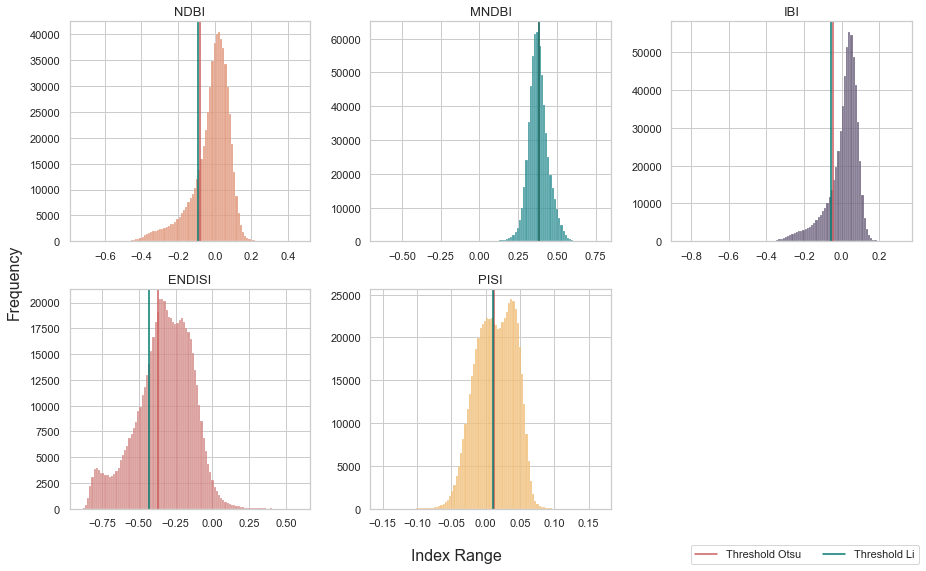

In [146]:
sns.set(style="whitegrid")  
fig,axs = plt.subplots(2,3, figsize = (13,8))

sns.histplot(array_2020["NDBI"], kde=False, color='#DC8665', bins=100, ax=axs[0, 0])
axs[0,0].set_title("NDBI", size=13)
axs[0,0].set_ylabel(None)
axs[0,0].axvline(-0.079, color='indianred', label='Threshold Otsu')
axs[0,0].axvline(-0.093, color='#01796f', label='Threshold Li')

sns.histplot(array_2020["MNDBI"], kde=False, color='#138086', bins=100, ax=axs[0, 1])
axs[0,1].set_title("MNDBI", size=13)
axs[0,1].set_ylabel(None)
axs[0,1].axvline(0.388, color='indianred', label='Threshold Otsu')
axs[0,1].axvline(0.386, color='#01796f', label='Threshold Li')


sns.histplot(array_2020["IBI"], kde=False, color='#534666', bins=100,ax=axs[0, 2])
axs[0,2].set_title("IBI", size=13)
axs[0,2].set_ylabel(None)
axs[0,2].axvline(-0.046, color='indianred', label='Threshold Otsu')
axs[0,2].axvline(-0.054, color='#01796f', label='Threshold Li')


sns.histplot(array_2020["ENDISI"], kde=False, color='#CD7672', bins=100, ax=axs[1, 0])
axs[1,0].set_title("ENDISI", size=13)
axs[1,0].set_ylabel(None)
axs[1,0].axvline(-0.367, color='indianred', label='Threshold Otsu')
axs[1,0].axvline(-0.429, color='#01796f', label='Threshold Li')

sns.histplot(array_2020["PISI"], kde=False, color='#EEB462', bins=100, ax=axs[1, 1])
axs[1,1].set_title("PISI", size=13)
axs[1,1].set_ylabel(None)
axs[1,1].axvline(0.013, color='indianred', label='Threshold Otsu')
axs[1,1].axvline(0.011, color='#01796f', label='Threshold Li')

labels = ['Threshold Otsu', 'Threshold Li']
fig.legend(labels, loc='lower right', bbox_to_anchor=(1, 0), ncol=len(labels), bbox_transform=fig.transFigure)

# fig.suptitle("Distribution of pixel values across urban indices in Addis Ababa in 2015", size=16)
fig.subplots_adjust(top=0.88)
fig.supxlabel("Index Range", size=16)
fig.supylabel("Frequency", size=16)
fig.delaxes(axs[1][2])
fig.tight_layout()
plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/pixel_dist_thresh.png', dpi=300)

In [ ]:
# # Get validation data
# ghsl_img = ee.ImageCollection('JRC/GHSL/P2016/BUILT_LDSMT_GLOBE_V1') \
#     .select("built") \
#     .gte(3) \
#     .clip(addis_bndry)

# ghsl = ghsl_img.resample('bicubic').reproject(crs=LS_projection, scale=30)
# ghsl_array = img2array1D(ghsl, "built")

### Get validation data and plot threshold data on map

In [156]:
# Get basemap layer and set it to Addis Ababa
map = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [88]:
esa_wc = ee.ImageCollection('ESA/WorldCover/v100')\
    .first() \
    .select("Map") \
    .eq(50) \
    .clip(addis_bndry)

# map.addLayer(esa_wc, {}, "ESA/WorldCover/v100 Mask")

In [157]:
# reproject to Landsat
LS_projection = y_2015.projection().getInfo()['crs']
esa_projection = esa_wc.projection().nominalScale().getInfo()
print(f"esa_projection: {esa_projection}")
esa_img = esa_wc.resample('bicubic').reproject(crs=LS_projection, scale=30)
esa_reproject = esa_img.projection().nominalScale().getInfo()
print(f"esa_reproject: {esa_reproject}")

map.addLayer(esa_img, {}, "ESA Reproject")

esa_projection: 9.276624232772797
esa_reproject: 30.000000000000004


In [90]:
esa_array = img2array1D(esa_img, "Map")
print(esa_array)

[0 0 0 ... 0 0 0]


### Automatic Thresholds

In [167]:
# NDBI
ndbi2020_ATO = y_2020.select("NDBI").gte(-0.079)
ndbi2020_ATL = y_2020.select("NDBI").gte(-0.093)

# MNDBI
mndbi2020_ATO = y_2020.select("MNDBI").lte(0.388)
mndbi2020_ATL = y_2020.select("MNDBI").lte(0.386)

# IBI
ibi2020_ATO = y_2020.select("IBI").gte(-0.046)
ibi2020_ATL = y_2020.select("IBI").gte(-0.054)

# ENDISI
endisi2020_ATO = y_2020.select("ENDISI").gte(-0.367)
endisi2020_ATL = y_2020.select("ENDISI").gte(-0.429)

# PISI
pisi2020_ATO = y_2020.select("PISI").gte(0.013)
pisi2020_ATL = y_2020.select("PISI").gte(0.011)

ATO_visuals = {"palette": ["black", "d7191c"]}
ATL_visuals = {"palette": ["black", "fdae61"]}

map.addLayer(ndbi2020_ATO, ATO_visuals, "NDBI 2020 ATO")
map.addLayer(ndbi2020_ATL, ATL_visuals, "NDBI 2020 ATL")

map.addLayer(mndbi2020_ATO, ATO_visuals, "MNDBI 2020 ATO")
map.addLayer(mndbi2020_ATL, ATL_visuals, "MNDBI 2020 ATL")

map.addLayer(ibi2020_ATO, ATO_visuals, "IBI 2020 ATO")
map.addLayer(ibi2020_ATL, ATL_visuals, "IBI 2020 ATL")

### Manual Thresholds

In [170]:
# # Based on the thresholds set out by the authors in their research

MT_visuals = {"palette": ["black", "2b83ba"]}


# # No threshold set
ndbi2020_MT = y_2020.select("NDBI").gte(0)

# # # 0.05-0.14
mndbi2020_MT = y_2020.select("MNDBI").lte(0.38)

# 0.013
ibi2020_MT = y_2020.select("IBI").gte(0.03)

# # -0.16 - -0.07
endisi2020_MT = y_2020.select("ENDISI").gte(-0.16)

# 0.26
pisi2020_MT = y_2020.select("PISI").gte(0.04)

map.addLayer(ndbi2020_MT, MT_visuals, "ndbi 2020 MT")
map.addLayer(mndbi2020_MT, MT_visuals, "mndbi 2020 MT")
map.addLayer(ibi2020_MT, MT_visuals, "ibi 2020 MT")

### NDBI Threshold

In [104]:
ndbiATO_array = img2array1D(ndbi2020_ATO, "NDBI")
ndbiATL_array = img2array1D(ndbi2020_ATL, "NDBI")
ndbiMT_array = img2array1D(ndbi2020_MT, "NDBI")

In [105]:
equal = 0
for i in range(0, len(ndbiATO_array)):
    if ndbiATO_array[i] == esa_array[i]:
        equal += 1
print(f"NDBI Otsu Threshold: {(equal/len(ndbiATO_array)*100):.2f}% accuracy")

NDBI Otsu Threshold: 40.04% accuracy


In [106]:
equal = 0

for i in range(0, len(ndbiATL_array)):
    if ndbiATL_array[i] == esa_array[i]:
        equal += 1
print(f"NDBI Li Threshold: {(equal/len(ndbiATL_array)*100):.2f}% accuracy")

NDBI Li Threshold: 39.11% accuracy


In [107]:
equal = 0

for i in range(0, len(ndbiMT_array)):
    if ndbiMT_array[i] == esa_array[i]:
        equal += 1
print(f"NDBI Manual Threshold: {(equal/len(ndbiMT_array)*100):.2f}% accuracy")

NDBI Manual Threshold: 49.38% accuracy


### MNDBI Threshold

In [108]:
mndbiATO_array = img2array1D(mndbi2020_ATO, "MNDBI")
mndbiATL_array = img2array1D(mndbi2020_ATL, "MNDBI")
mndbiMT_array = img2array1D(mndbi2020_MT, "MNDBI")

In [109]:
equal = 0
for i in range(0, len(mndbiATO_array)):
    if mndbiATO_array[i] == esa_array[i]:
        equal += 1
print(f"MNDBI Otsu Threshold: {(equal/len(mndbiATO_array)*100):.2f}% accuracy")

MNDBI Otsu Threshold: 48.01% accuracy


In [110]:
equal = 0

for i in range(0, len(mndbiATL_array)):
    if mndbiATL_array[i] == esa_array[i]:
        equal += 1
print(f"MNDBI Li Threshold: {(equal/len(mndbiATL_array)*100):.2f}% accuracy")

MNDBI Li Threshold: 48.54% accuracy


In [111]:
equal = 0

for i in range(0, len(mndbiMT_array)):
    if mndbiMT_array[i] == esa_array[i]:
        equal += 1
print(f"MNDBI Manual Threshold: {(equal/len(mndbiMT_array)*100):.2f}% accuracy")

MNDBI Manual Threshold: 50.17% accuracy


### IBI Threshold

In [112]:
ibiATO_array = img2array1D(ibi2020_ATO, "IBI")
ibiATL_array = img2array1D(ibi2020_ATL, "IBI")
ibiMT_array = img2array1D(ibi2020_MT, "IBI")

In [113]:
equal = 0
for i in range(0, len(ibiATO_array)):
    if ibiATO_array[i] == esa_array[i]:
        equal += 1
print(f"IBI Otsu Threshold: {(equal/len(ibiATO_array)*100):.2f}% accuracy")

IBI Otsu Threshold: 39.38% accuracy


In [114]:
equal = 0

for i in range(0, len(ibiATL_array)):
    if ibiATL_array[i] == esa_array[i]:
        equal += 1
print(f"IBI Li Threshold: {(equal/len(ibiATL_array)*100):.2f}% accuracy")

IBI Li Threshold: 38.79% accuracy


In [115]:
equal = 0

for i in range(0, len(ibiMT_array)):
    if ibiMT_array[i] == esa_array[i]:
        equal += 1
print(f"IBI Manual Threshold: {(equal/len(ibiMT_array)*100):.2f}% accuracy")

IBI Manual Threshold: 50.54% accuracy


### Get another map for ENDISI and PISI

In [116]:
# Get basemap layer and set it to Addis Ababa
map2 = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map2

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [184]:
png_file = os.path.join(download_dir, 'endisi_mt.png')
map.to_image(filename=png_file, monitor=2)

In [178]:
map2.addLayer(esa_img, {}, "ESA Reproject")

map2.addLayer(endisi2020_ATO, ATO_visuals, "ENDISI 2020 ATO")
map2.addLayer(endisi2020_ATL, ATL_visuals, "ENDISI 2020 ATL")
map2.addLayer(endisi2020_MT, MT_visuals, "ENDISI 2020 MT")

map2.addLayer(pisi2020_ATO, ATO_visuals, "PISI 2020 ATO")
map2.addLayer(pisi2020_ATL, ATL_visuals, "PISI 2020 ATL")
map2.addLayer(pisi2020_MT, MT_visuals, "pisi 2020 MT")

### ENDISI Threshold

In [118]:
endisiATO_array = img2array1D(endisi2020_ATO, "ENDISI")
endisiATL_array = img2array1D(endisi2020_ATL, "ENDISI")
endisiMT_array = img2array1D(endisi2020_MT, "ENDISI")

In [119]:
equal = 0
for i in range(0, len(endisiATO_array)):
    if endisiATO_array[i] == esa_array[i]:
        equal += 1
print(f"Endisi Otsu Threshold: {(equal/len(endisiATO_array)*100):.2f}% accuracy")

Endisi Otsu Threshold: 46.93% accuracy


In [120]:
equal = 0

for i in range(0, len(endisiATL_array)):
    if endisiATL_array[i] == esa_array[i]:
        equal += 1
print(f"Endisi Li Threshold: {(equal/len(endisiATL_array)*100):.2f}% accuracy")

Endisi Li Threshold: 42.84% accuracy


In [121]:
equal = 0

for i in range(0, len(endisiMT_array)):
    if endisiMT_array[i] == esa_array[i]:
        equal += 1
print(f"Endisi Manual Threshold: {(equal/len(endisiMT_array)*100):.2f}% accuracy")

Endisi Manual Threshold: 62.35% accuracy


### PISI Threshold

In [132]:
pisiATO_array = img2array1D(pisi2020_ATO, "PISI")
pisiATL_array = img2array1D(pisi2020_ATL, "PISI")
pisiMT_array = img2array1D(pisi2020_MT, "PISI")

In [123]:
equal = 0
for i in range(0, len(pisiATO_array)):
    if pisiATO_array[i] == esa_array[i]:
        equal += 1
print(f"Endisi Otsu Threshold: {(equal/len(pisiATO_array)*100):.2f}% accuracy")

Endisi Otsu Threshold: 48.71% accuracy


In [124]:
equal = 0

for i in range(0, len(pisiATL_array)):
    if pisiATL_array[i] == esa_array[i]:
        equal += 1
print(f"Endisi Li Threshold: {(equal/len(pisiATL_array)*100):.2f}% accuracy")

Endisi Li Threshold: 47.91% accuracy


In [141]:
equal = 0

for i in range(0, len(pisiMT_array)):
    if pisiMT_array[i] == esa_array[i]:
        equal += 1
print(f"PISI Manual Threshold: {(equal/len(pisiMT_array)*100):.2f}% accuracy")

PISI Manual Threshold: 60.38% accuracy


In [ ]:
# list_of_bands = ["NDBI", "MNDBI", "IBI", "ENDISI", "PISI"]
# label = 'built'
# scaleFactor=30

# points = ghsl_img.sample(**{"region":addis_bndry, "scale":scaleFactor,"seed":0,'geometries':True})

# data = y_2015.select(list_of_bands).sampleRegions(collection=points, properties=[label], scale=scaleFactor)

# data.aggregate_stats(label).getInfo()

In [ ]:
# # reproject to Landsat
# LS_projection = y_2015.projection().getInfo()['crs']
# old_scale = ghsl_img.projection().nominalScale().getInfo()
# ghsl = ghsl_img.resample('bicubic').reproject(crs=LS_projection, scale=30)
# new_scale = ghsl.projection().nominalScale().getInfo()

# print(f"Original GHSL scale: {old_scale}, Reprojected Scale: {new_scale}")

### Calculate the area

In [185]:
def area(index):
    self_mask = index.selfMask()
    vector = self_mask.reduceToVectors(geometry=addis_bndry, scale=30, maxPixels=60000000)
    area = vector.geometry().area(1).divide(1e6).round().getInfo()
    return area

esa_area = area(esa_img)

pisi_2020_area = area(pisi2020_MT)


In [145]:
esa_area

166

In [186]:
pisi_2020_area

115

In [190]:
### For downloading the images

# download_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
# png_file = os.path.join(download_dir, 'ndbi_mt.png')
# map.to_image(filename=png_file, monitor=2)